In [14]:
# sarcasm json data binary classification
# total 26,709 headlines
import json
import tensorflow as tf
import numpy as np
import urllib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# sarcasm.json 데이터셋 파일 다운로드 , Windows용
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x1ef48bf7d00>)

In [4]:
with open('sarcasm.json','r') as f:
    datastore = json.load(f)
    
sentances = []
labels = []

for item in datastore:
    sentances.append(item['headline'])
    labels.append(item['is_sarcastic'])

### 텍스트 전처리: Tokenizer

In [6]:
# 전처리를 위한 변수 설정
vocab_size = 10000 #Token화에 사용될 최대 어휘 수
embedding_dim = 16 #embedding
max_length = 100   #한 문장의 길이, 데이터 셋의 길이, maxlen
trunc_type = 'post' #maxlen 보다 문장이 클 때 잘라낼 유형
padding_type = 'post' #maxlen 보다 문장이 작을 때 잘라낼 유형
oov_tok = "<<OOV>>" #단어 집합에 없는 단어(의미없는 단어) (out of vocabulary)
training_size = 20000 #학습데이터의 갯수

In [8]:
# train(20000)/test(6709) data split
training_sentences = sentances[:training_size]
training_labels = labels[:training_size]

testing_sentences = sentances[:training_size]
testing_labels = labels[:training_size]

In [13]:
# 토크나이저를 실행하여 단어를 숫자값, 인덱스로 변환하여 저장
# 가장 빈도가 높은 10000개 단어들만 사용하여 토큰화
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)

#단어 인덱스 구축
tokenizer.fit_on_texts(training_sentences)
word_index=tokenizer.word_index
#print(word_index)

training_sequences = tokenizer.texts_to_sequences(training_sentences) # type은 list
#print(training_sentences[0])

# padding, vactor 표현을 얻음: 신경망에 입력할 X값
training_padded = pad_sequences(training_sequences,maxlen=max_length,
                                padding=padding_type,truncating=trunc_type)
#print(training_padded[0])
#print(training_padded.shape)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

testing_padded = pad_sequences(testing_sequences,maxlen=max_length,
                                padding=padding_type,truncating=trunc_type)

In [15]:
# list를 array로 변환
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

### 학습모델

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), # feature를 1차원 vector로 변환
    tf.keras.layers.Dense(24,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 24)                408       
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 학습
history = model.fit(training_padded,training_labels,epochs=30,
                    validation_data=(testing_padded,testing_labels))

Epoch 1/30
625/625 [==============================] - 7s 8ms/step - loss: 0.6652 - accuracy: 0.5885 - val_loss: 0.5768 - val_accuracy: 0.6898
Epoch 2/30
625/625 [==============================] - 5s 7ms/step - loss: 0.4361 - accuracy: 0.8285 - val_loss: 0.3357 - val_accuracy: 0.8745
Epoch 3/30
625/625 [==============================] - 5s 7ms/step - loss: 0.3157 - accuracy: 0.8755 - val_loss: 0.2770 - val_accuracy: 0.8905
Epoch 4/30
625/625 [==============================] - 4s 7ms/step - loss: 0.2637 - accuracy: 0.8975 - val_loss: 0.2322 - val_accuracy: 0.9135
Epoch 5/30
625/625 [==============================] - 4s 7ms/step - loss: 0.2277 - accuracy: 0.9129 - val_loss: 0.2152 - val_accuracy: 0.9163
Epoch 6/30
625/625 [==============================] - 4s 7ms/step - loss: 0.1997 - accuracy: 0.9245 - val_loss: 0.1759 - val_accuracy: 0.9362
Epoch 7/30
625/625 [==============================] - 4s 7ms/step - loss: 0.1779 - accuracy: 0.9329 - val_loss: 0.1564 - val_accuracy: 0.9437
Epoch 

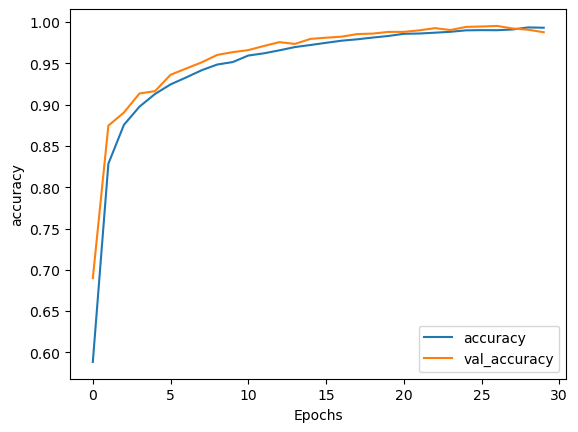

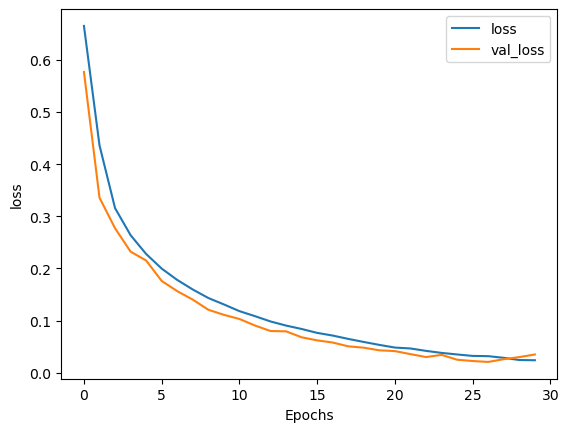

In [24]:
# 시각화
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### 모델 개선

In [32]:
# LSTM 사용 시
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length), #희소벡터가 밀집벡터로 변환
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64,return_sequences=True)), #units(:N), resutn_sequences(N dimention)
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32,)),
    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.GlobalAveragePooling1D(), # feature를 1차원 vector로 변환
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 16)           160000    
                                                                 
 dropout_4 (Dropout)         (None, 100, 16)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 100, 128)         41472     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 100, 128)          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)              

In [33]:
# 학습
history = model.fit(training_padded,training_labels,epochs=30,
                    validation_data=(testing_padded,testing_labels))

Epoch 1/30
625/625 [==============================] - 54s 80ms/step - loss: 0.4164 - accuracy: 0.7958 - val_loss: 0.2149 - val_accuracy: 0.9223
Epoch 2/30
625/625 [==============================] - 51s 82ms/step - loss: 0.2323 - accuracy: 0.9066 - val_loss: 0.1380 - val_accuracy: 0.9570
Epoch 3/30
625/625 [==============================] - 45s 72ms/step - loss: 0.1613 - accuracy: 0.9379 - val_loss: 0.0922 - val_accuracy: 0.9758
Epoch 4/30
625/625 [==============================] - 46s 74ms/step - loss: 0.1109 - accuracy: 0.9577 - val_loss: 0.0590 - val_accuracy: 0.9837
Epoch 5/30
625/625 [==============================] - 47s 75ms/step - loss: 0.0852 - accuracy: 0.9690 - val_loss: 0.0555 - val_accuracy: 0.9815
Epoch 6/30
625/625 [==============================] - 50s 81ms/step - loss: 0.0635 - accuracy: 0.9772 - val_loss: 0.0391 - val_accuracy: 0.9889
Epoch 7/30
625/625 [==============================] - 44s 71ms/step - loss: 0.0552 - accuracy: 0.9798 - val_loss: 0.0278 - val_accuracy:

In [35]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[2]))
print(training_sentences[2])
print(labels[2])

mom starting to fear son's web series closest thing she will have to grandchild ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [36]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [46]:
# 예측
sentence = ["Head of Canada's spy agency announces he's stepping down from the job",
            "Old Video of Joe Biden Talking About Resignation Falsely Shared as Recent"]
sequneces = tokenizer.texts_to_sequences(sentence)
padded_data = pad_sequences(sequneces,maxlen=max_length,padding=padding_type,truncating=trunc_type)
padded_data.shape
preds = model.predict(padded_data)
print(preds)

1/1 [==============================] - 0s 24ms/step
[[0.99998236]
 [0.9999999 ]]


In [47]:
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

tokenizer = Tokenizer(num_words = 100, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences, maxlen=5)
print("\nWord Index = " , word_index)
print("\nSequences = " , sequences)
print("\nPadded Sequences:")
print(padded)


# Try with words that the tokenizer wasn't fit to
test_data = [
    'i really love my dog',
    'my dog loves my manatee'
]

test_seq = tokenizer.texts_to_sequences(test_data)
print("\nTest Sequence = ", test_seq)

padded = pad_sequences(test_seq, maxlen=10)
print("\nPadded Test Sequence: ")
print(padded)


Word Index =  {'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}

Sequences =  [[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]

Padded Sequences:
[[ 0  5  3  2  4]
 [ 0  5  3  2  7]
 [ 0  6  3  2  4]
 [ 9  2  4 10 11]]

Test Sequence =  [[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]

Padded Test Sequence: 
[[0 0 0 0 0 5 1 3 2 4]
 [0 0 0 0 0 2 4 1 2 1]]
